The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


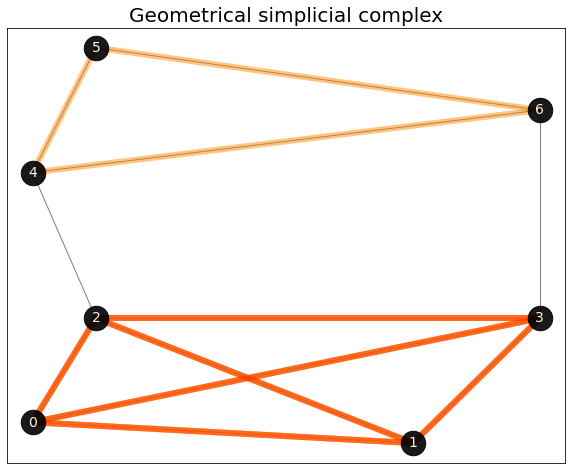

<Figure size 432x288 with 0 Axes>

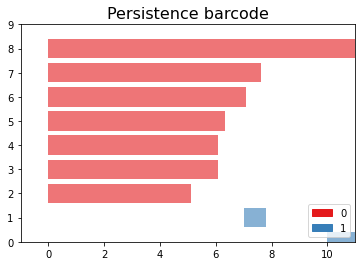

In [19]:
'''
The following program computes the topological properties of a cloud of points using a coordinates file as input
We must have in the same folder where the program is executed a 'points.txt' file with numbers stored in the following format:
       1.23 4.56
       6.78 9.01
       12.43 -12.02
They can be either integer or float

Additionally, we must have the 'TDA.py' file with the Topological analysis functions created at:
    https://github.com/multinetlab-amsterdam/network_TDA_tutorial

As an output, it creates a 'Results' folder with 4 new files:
    - Result_SC.txt: with the abstract information of the resulting simplicial complex
    - Geometrical_SC.png: geometrical representation of the simplicial complex, highlighting the relevant simplices
    - Persistence_barcode.png: plot of the persistence homology properties
    - Betti_numbers.txt: with the computation of the Betti numbers 
'''


# Import required Python packages
import numpy as np # version 1.18.5
import networkx as nx # version 2.4
import community # version 0.13 (python-louvain)
import gudhi # version 3.3.0
import itertools

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import scipy.io # version 1.4.1
from sklearn import preprocessing # version 0.23.1
import itertools

import seaborn as sns
import pandas as pd
import glob
from pathlib import Path

%load_ext watermark

import os
if not os.path.exists('Results'):
    os.makedirs('Results')

# Create Graph class
class Graph(object):

    # Initialize the matrix
    def __init__(self, size):
        self.adjMatrix = []
        for i in range(size):
            self.adjMatrix.append([0 for i in range(size)])
        self.size = size

    # Add edges
    def add_edge(self, v1, v2):
        if v1 == v2:
            print("Same vertex %d and %d" % (v1, v2))
        self.adjMatrix[v1][v2] = 1
        self.adjMatrix[v2][v1] = 1

    # Remove edges
    def remove_edge(self, v1, v2):
        if self.adjMatrix[v1][v2] == 0:
            print("No edge between %d and %d" % (v1, v2))
            return
        self.adjMatrix[v1][v2] = 0
        self.adjMatrix[v2][v1] = 0

    def __len__(self):
        return self.size

    # Print the matrix
    def print_matrix(self):
        print(np.array(self.adjMatrix))
        
# Load the set of points (input raw data)
data_A_sample = list()
for line in open('points.txt', 'r'): 
    row = line.split()
    data_A_sample.append((float(row[0]),float(row[1])))    

# Parameters
field_extension = 10.0 #Maximum entension of a synaptic field to create an edge
maxsimplex = len(data_A_sample) #We need to specify a maximum dimension of a simplex to make a computationally efficient program
n_vertices = len(data_A_sample)
position_dict = {i:data_A_sample[i] for i in range(n_vertices)} # To specify the position of our nodes in networkx package

g = Graph(n_vertices)

# Create simplicial complex
rips_complex = gudhi.RipsComplex(points=data_A_sample, max_edge_length=field_extension)
st = rips_complex.create_simplex_tree(max_dimension=maxsimplex)

# Note that, if there are n vertices, then the maximum number of edges is n*(n-1)
result_str = 'Simplicial complex is of dimension ' + repr(st.dimension()) + ' - ' + \
    repr(st.num_simplices()) + ' simplices - ' + \
    repr(n_vertices) + ' vertices.'

filtration = st.get_filtration()

with open('./Results/Result_SC.txt','w+') as file:
    file.write(result_str)
    file.write('\nAbstract simplicial complex: (Simplex -> Filtration value)\n')
    for filtered_value in filtration:
        file.write("%s -> %.2f\n" % tuple(filtered_value))
        simplex = filtered_value[0]
        if(len(simplex)==2):
            g.add_edge(simplex[0],simplex[1])
    
cmap = cm.hot
norm = Normalize(vmin=0, vmax=maxsimplex)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

# Visualize matrix as graph, highlighting the relevant simplices
A = np.array(g.adjMatrix)
G = nx.from_numpy_matrix(A)  

plt.figure(figsize=(10,8))
pos = position_dict  # positions for all nodes

options = {"node_color": "black", "edgecolors": "black", "node_size": 600, "alpha": 0.9}

nx.draw_networkx_nodes(G, pos, **options)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5) # Background network with all edges

n_theta = 3
min_d = n_theta
max_d = 4

filtration = st.get_filtration()
for filtered_value in filtration:
    simplex = filtered_value[0]
    for dim in range(min_d,max_d+1):
        if(len(simplex)==dim):
            edges = list(itertools.combinations(simplex, 2)) #Return 2 length subsequences of elements from the input simplex.
            nx.draw_networkx_edges(
                G,
                pos,
                edgelist=edges,
                width=6,
                alpha=0.5,
                edge_color = m.to_rgba(maxsimplex-dim)
            )

labels = {i:i for i in range(n_vertices)}

nx.draw_networkx_labels(G, pos, labels, font_size=14, font_color="whitesmoke")

plt.title('Geometrical simplicial complex',fontsize=20)
plt.draw()
plt.savefig('./Results/Geometrical_SC.png')

plt.figure()
diag = st.persistence(min_persistence=0.1)
gudhi.plot_persistence_barcode(diag, legend=True, max_intervals=0)
plt.savefig('./Results/Persistence_barcode.png')

# Import TDA functions
%run "./TDA.py"

# Compute Betti numbers
with open('./Results/Betti_numbers.txt','w') as file:
    for i in range(max_d+1):
        file.write("Betti number %s: %s\n" % (i,Betti_k(G,i)))